## Interpretation

The goal of after model training in 04_model_training.ipynb is to understand how each model makes predictions on new data. Permutation feature importance and SHAP are useful in making the results interpretable, explaining how each feature affects the models' predictions.

Permutation feature importance is a global model-agnostic post-hoc method, measuring the increase in the prediction error of the model after permuting the values of a feature. A larger increase in prediction error indicates higher feature importance. However, feature importance does not inform how the feature influences the prediction as it is measured by prediction error. Feature importance is just an internal ranking of features.

SHapley Additive exPlanations (SHAP) is a local model-agnostic post-hoc method, explaining the prediction of a model by computing the contribution of each feature to the prediction. Unlike permutation feature importance, the SHAP summary plot combines feature importance with feature effects. The summary plot orders the features by importance in the y-axis, and shows how that feature increases or decreases the prediction relative to the base value, given a high or low feature value.

Reference : https://christophm.github.io/interpretable-ml-book/overview.html

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle
import tensorflow as tf

In [2]:
# Read the data and re-introduce the train-test split
df = pd.read_csv("../data/processed/nhanes_data_processed_label_encoded.csv")

with open("../data/results/split_data.pkl", "rb") as f:
    split_data = pickle.load(f)

with open("../data/results/metadata.pkl", "rb") as f:
    metadata = pickle.load(f)
feature_names = metadata["feature_names"]

RANDOM_STATE = 42
X_train = split_data["X_train"]
X_train_scaled = split_data["X_train_scaled"]
y_train = split_data["y_train"]
X_test = split_data["X_test"]
X_test_scaled = split_data["X_test_scaled"]
y_test = split_data["y_test"]

In [3]:
# Load models
dt_model = joblib.load('../models/decision_tree_model.pkl')
rf_model = joblib.load('../models/random_forest_model.pkl')
xgb_model = joblib.load('../models/xgboost_model.pkl')
adb_model = joblib.load('../models/adaboost_model.pkl')
lgr_model = joblib.load('../models/logistic_regression_model.pkl')
knn_model = joblib.load('../models/k-nearest_neighbors_model.pkl')
svc_model = joblib.load('../models/support_vector_machine_model.pkl')
nn_model = tf.keras.models.load_model("../models/neural_network_model.keras", compile=True)

models = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "AdaBoost": adb_model,
    "Logistic Regression": lgr_model,
    "K-Nearest Neighbors": knn_model,
    "Support Vector Machine": svc_model,
    "Neural Network": nn_model
}

## Permutation Feature Importance

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance

In [4]:
from sklearn.inspection import permutation_importance

In [5]:
# Create a wrapper class for the neural network model to use with sklearn
from sklearn.base import BaseEstimator

class NeuralNetworkWrapper(BaseEstimator):
    def __init__(self, model, scaler=None):
        self.model = model
        self.scaler = scaler
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        """Return class predictions"""
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X
            
        logits = self.model.predict(X_scaled, verbose=0)
        return np.argmax(logits, axis=1)
    
    def predict_proba(self, X):
        """Return class probabilities"""
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X
            
        logits = self.model.predict(X_scaled, verbose=0)
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [6]:
# Calculate permutation importance for each model
perm_importance_results = {}

for model_name, model in models.items():
    if model_name != "Neural Network":
        perm_result = permutation_importance(model, X_test, y_test,
                                            scoring="f1_macro",
                                            n_repeats=10,
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE
                                            )
    else:
        nn_wrapper = NeuralNetworkWrapper(nn_model)
        perm_result = permutation_importance(nn_wrapper, X_test_scaled, y_test,
                                            scoring="f1_macro",
                                            n_repeats=10,
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE
                                            )
    perm_importance_results[model_name] = pd.DataFrame({"feature" : feature_names,
                                                            "importance_mean": perm_result.importances_mean,
                                                            "importance_std": perm_result.importances_std,                       
                                }).sort_values("importance_mean", ascending=False)

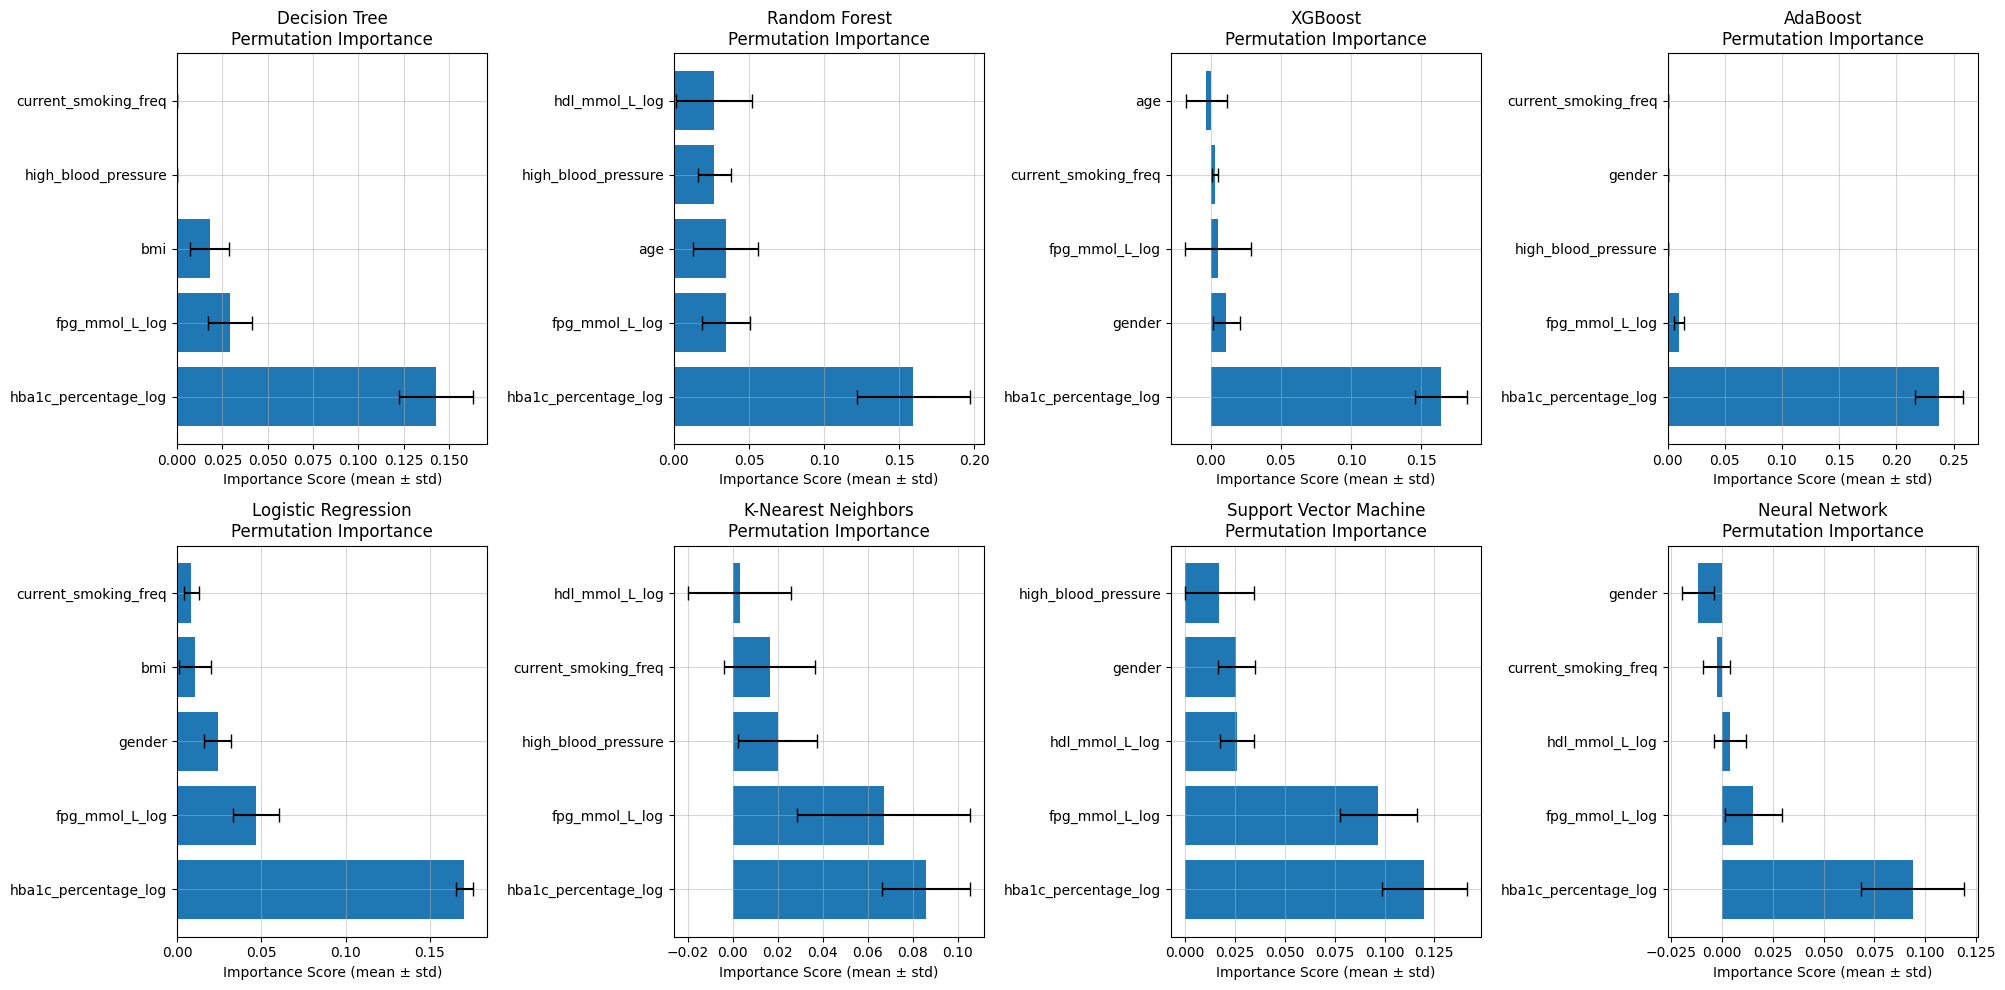

In [7]:
# Create visualisation of permutation importance for each model
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.ravel()

for idx, (model_name, importance_df) in enumerate(perm_importance_results.items()):
    ax = axes[idx]
    
    # Display the top 5 features only
    top_features = importance_df.head(5)
    
    ax.barh(range(len(top_features)), top_features["importance_mean"], xerr=top_features["importance_std"], capsize=5)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features["feature"])
    ax.set_xlabel("Importance Score (mean ± std)")
    ax.set_title(f"{model_name}\nPermutation Importance")
    ax.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
# Create comparison table
importance_comparison = pd.DataFrame()

for model_name, importance_df in perm_importance_results.items():
    importance_comparison[model_name] = importance_df.set_index("feature")["importance_mean"]

importance_comparison["Average"] = importance_comparison.mean(axis=1)
importance_comparison = importance_comparison.sort_values("Average", ascending=False)

print("Feature importance comparison across models:")
print(importance_comparison.round(4))

Feature importance comparison across models:
                      Decision Tree  Random Forest  XGBoost  AdaBoost  \
feature                                                                 
hba1c_percentage_log         0.1426         0.1593   0.1641    0.2373   
fpg_mmol_L_log               0.0293         0.0346   0.0053    0.0098   
gender                       0.0000         0.0195   0.0111    0.0000   
hdl_mmol_L_log               0.0000         0.0267  -0.0052    0.0000   
current_smoking_freq         0.0000         0.0123   0.0033    0.0000   
bmi                          0.0182         0.0233  -0.0052   -0.0017   
high_blood_pressure          0.0000         0.0270  -0.0066    0.0000   
age                         -0.0310         0.0345  -0.0032    0.0000   

                      Logistic Regression  K-Nearest Neighbors  \
feature                                                          
hba1c_percentage_log               0.1704               0.0857   
fpg_mmol_L_log            

## SHAP (SHapeley Additive exPlanations)

Reference : https://shap.readthedocs.io/en/latest/api.html#explanation

In [9]:
import shap

c:\Users\ryans\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# For Tree-based models (AdaBoost is not supported)
dt_explainer = shap.TreeExplainer(dt_model)
dt_shap_values = dt_explainer.shap_values(X_test)

rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test)

xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)

In [11]:
# For all other models, use KernelExplainer
background = shap.sample(X_train, 100)
background_scaled = shap.sample(X_train_scaled, 100)

adb_explainer = shap.KernelExplainer(adb_model.predict_proba, background)
adb_shap_values = adb_explainer.shap_values(X_test)

lgr_explainer = shap.KernelExplainer(lambda x: lgr_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
lgr_shap_values = lgr_explainer.shap_values(X_test)

knn_explainer = shap.KernelExplainer(lambda x: knn_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
knn_shap_values = knn_explainer.shap_values(X_test)

svc_explainer = shap.KernelExplainer(lambda x: svc_model.predict_proba(pd.DataFrame(x, columns=feature_names)), background)
svc_shap_values = svc_explainer.shap_values(X_test)

nn_explainer = shap.KernelExplainer(lambda x: nn_model.predict(pd.DataFrame(x, columns=feature_names)), background_scaled)
nn_shap_values = nn_explainer.shap_values(X_test_scaled)


100%|██████████| 227/227 [01:35<00:00,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 



  0%|          | 0/227 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step


  0%|          | 1/227 [00:00<03:32,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step


  1%|          | 2/227 [00:01<03:28,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step


  1%|▏         | 3/227 [00:02<03:22,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step


  2%|▏         | 4/227 [00:03<03:18,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step


  2%|▏         | 5/227 [00:04<03:17,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step


  3%|▎         | 6/227 [00:05<03:16,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step


  3%|▎         | 7/227 [00:06<03:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step


  4%|▎         | 8/227 [00:07<03:15,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step


  4%|▍         | 9/227 [00:08<03:13,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step


  4%|▍         | 10/227 [00:08<03:11,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step


  5%|▍         | 11/227 [00:09<03:11,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step


  5%|▌         | 12/227 [00:10<03:10,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step


  6%|▌         | 13/227 [00:11<03:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step


  6%|▌         | 14/227 [00:12<03:08,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step


  7%|▋         | 15/227 [00:13<03:06,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step


  7%|▋         | 16/227 [00:14<03:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step


  7%|▋         | 17/227 [00:15<03:07,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step


  8%|▊         | 18/227 [00:16<03:04,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step


  8%|▊         | 19/227 [00:16<03:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step


  9%|▉         | 20/227 [00:17<03:01,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step


  9%|▉         | 21/227 [00:18<02:59,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step


 10%|▉         | 22/227 [00:19<02:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step


 10%|█         | 23/227 [00:20<02:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step


 11%|█         | 24/227 [00:21<02:58,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step


 11%|█         | 25/227 [00:22<02:56,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step


 11%|█▏        | 26/227 [00:22<02:55,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step


 12%|█▏        | 27/227 [00:23<02:57,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step


 12%|█▏        | 28/227 [00:24<02:55,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step


 13%|█▎        | 29/227 [00:25<02:53,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step


 13%|█▎        | 30/227 [00:26<02:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step


 14%|█▎        | 31/227 [00:27<02:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step


 14%|█▍        | 32/227 [00:28<02:51,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step


 15%|█▍        | 33/227 [00:29<02:53,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step


 15%|█▍        | 34/227 [00:30<02:51,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step


 15%|█▌        | 35/227 [00:30<02:49,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step


 16%|█▌        | 36/227 [00:31<02:46,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step


 16%|█▋        | 37/227 [00:32<02:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step


 17%|█▋        | 38/227 [00:33<02:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step


 17%|█▋        | 39/227 [00:34<02:49,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step


 18%|█▊        | 40/227 [00:35<02:46,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step


 18%|█▊        | 41/227 [00:36<02:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step


 19%|█▊        | 42/227 [00:37<02:47,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step


 19%|█▉        | 43/227 [00:38<02:45,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step


 19%|█▉        | 44/227 [00:39<02:45,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step


 20%|█▉        | 45/227 [00:39<02:41,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step


 20%|██        | 46/227 [00:40<02:40,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step


 21%|██        | 47/227 [00:41<02:38,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step


 21%|██        | 48/227 [00:42<02:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step


 22%|██▏       | 49/227 [00:43<02:36,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step


 22%|██▏       | 50/227 [00:44<02:36,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step


 22%|██▏       | 51/227 [00:45<02:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step


 23%|██▎       | 52/227 [00:46<02:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step


 23%|██▎       | 53/227 [00:46<02:31,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step


 24%|██▍       | 54/227 [00:47<02:31,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step


 24%|██▍       | 55/227 [00:48<02:29,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step


 25%|██▍       | 56/227 [00:49<02:34,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step


 25%|██▌       | 57/227 [00:50<02:31,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step


 26%|██▌       | 58/227 [00:51<02:29,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step


 26%|██▌       | 59/227 [00:52<02:28,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step


 26%|██▋       | 60/227 [00:53<02:27,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step


 27%|██▋       | 61/227 [00:54<02:27,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step


 27%|██▋       | 62/227 [00:54<02:28,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step


 28%|██▊       | 63/227 [00:56<02:39,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step


 28%|██▊       | 64/227 [00:57<02:45,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step


 29%|██▊       | 65/227 [00:58<02:48,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step


 29%|██▉       | 66/227 [00:59<02:52,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step


 30%|██▉       | 67/227 [01:00<02:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step


 30%|██▉       | 68/227 [01:01<02:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step


 30%|███       | 69/227 [01:02<02:52,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step


 31%|███       | 70/227 [01:03<02:51,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step


 31%|███▏      | 71/227 [01:04<02:50,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step


 32%|███▏      | 72/227 [01:05<02:43,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step


 32%|███▏      | 73/227 [01:06<02:33,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step


 33%|███▎      | 74/227 [01:07<02:26,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step


 33%|███▎      | 75/227 [01:08<02:28,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step


 33%|███▎      | 76/227 [01:09<02:27,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step


 34%|███▍      | 77/227 [01:10<02:24,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step


 34%|███▍      | 78/227 [01:11<02:24,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step


 35%|███▍      | 79/227 [01:12<02:21,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step


 35%|███▌      | 80/227 [01:13<02:20,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step


 36%|███▌      | 81/227 [01:14<02:20,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step


 36%|███▌      | 82/227 [01:15<02:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step


 37%|███▋      | 83/227 [01:16<02:21,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step


 37%|███▋      | 84/227 [01:17<02:24,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step


 37%|███▋      | 85/227 [01:18<02:21,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step


 38%|███▊      | 86/227 [01:19<02:19,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step


 38%|███▊      | 87/227 [01:20<02:16,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step


 39%|███▉      | 88/227 [01:21<02:13,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step


 39%|███▉      | 89/227 [01:22<02:12,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step


 40%|███▉      | 90/227 [01:23<02:12,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step


 40%|████      | 91/227 [01:24<02:11,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step


 41%|████      | 92/227 [01:25<02:09,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step


 41%|████      | 93/227 [01:26<02:07,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step


 41%|████▏     | 94/227 [01:27<02:06,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step


 42%|████▏     | 95/227 [01:27<02:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step


 42%|████▏     | 96/227 [01:28<02:03,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step


 43%|████▎     | 97/227 [01:29<02:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step


 43%|████▎     | 98/227 [01:30<02:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step


 44%|████▎     | 99/227 [01:31<02:04,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step


 44%|████▍     | 100/227 [01:32<02:01,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step


 44%|████▍     | 101/227 [01:33<02:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step


 45%|████▍     | 102/227 [01:34<02:04,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step


 45%|████▌     | 103/227 [01:35<02:01,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step


 46%|████▌     | 104/227 [01:36<01:58,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step


 46%|████▋     | 105/227 [01:37<01:56,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step


 47%|████▋     | 106/227 [01:38<01:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step


 47%|████▋     | 107/227 [01:39<01:58,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step


 48%|████▊     | 108/227 [01:40<01:55,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step


 48%|████▊     | 109/227 [01:41<01:54,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step


 48%|████▊     | 110/227 [01:42<01:52,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step


 49%|████▉     | 111/227 [01:43<01:49,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step


 49%|████▉     | 112/227 [01:44<01:49,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step


 50%|████▉     | 113/227 [01:45<01:47,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step


 50%|█████     | 114/227 [01:46<01:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step


 51%|█████     | 115/227 [01:47<01:52,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step


 51%|█████     | 116/227 [01:48<01:55,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step


 52%|█████▏    | 117/227 [01:49<01:58,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step


 52%|█████▏    | 118/227 [01:50<01:57,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step


 52%|█████▏    | 119/227 [01:51<01:52,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step


 53%|█████▎    | 120/227 [01:52<01:48,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step


 53%|█████▎    | 121/227 [01:53<01:44,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step


 54%|█████▎    | 122/227 [01:54<01:42,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step


 54%|█████▍    | 123/227 [01:55<01:40,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step


 55%|█████▍    | 124/227 [01:56<01:37,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step


 55%|█████▌    | 125/227 [01:57<01:36,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step


 56%|█████▌    | 126/227 [01:58<01:36,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step


 56%|█████▌    | 127/227 [01:59<01:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step


 56%|█████▋    | 128/227 [02:00<01:35,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step


 57%|█████▋    | 129/227 [02:01<01:34,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step


 57%|█████▋    | 130/227 [02:02<01:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step


 58%|█████▊    | 131/227 [02:03<01:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step


 58%|█████▊    | 132/227 [02:04<01:30,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step


 59%|█████▊    | 133/227 [02:05<01:28,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step


 59%|█████▉    | 134/227 [02:05<01:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step


 59%|█████▉    | 135/227 [02:06<01:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step


 60%|█████▉    | 136/227 [02:07<01:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step


 60%|██████    | 137/227 [02:08<01:25,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step


 61%|██████    | 138/227 [02:09<01:25,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step


 61%|██████    | 139/227 [02:10<01:24,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step


 62%|██████▏   | 140/227 [02:11<01:22,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step


 62%|██████▏   | 141/227 [02:12<01:21,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step


 63%|██████▎   | 142/227 [02:13<01:19,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step


 63%|██████▎   | 143/227 [02:14<01:20,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step


 63%|██████▎   | 144/227 [02:15<01:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step


 64%|██████▍   | 145/227 [02:16<01:17,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step


 64%|██████▍   | 146/227 [02:17<01:16,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step


 65%|██████▍   | 147/227 [02:18<01:14,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step


 65%|██████▌   | 148/227 [02:19<01:15,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step


 66%|██████▌   | 149/227 [02:20<01:13,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step


 66%|██████▌   | 150/227 [02:21<01:13,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step


 67%|██████▋   | 151/227 [02:22<01:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step


 67%|██████▋   | 152/227 [02:23<01:10,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step


 67%|██████▋   | 153/227 [02:24<01:10,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step


 68%|██████▊   | 154/227 [02:24<01:09,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step


 68%|██████▊   | 155/227 [02:25<01:08,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step


 69%|██████▊   | 156/227 [02:26<01:06,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step


 69%|██████▉   | 157/227 [02:27<01:06,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step


 70%|██████▉   | 158/227 [02:28<01:05,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step


 70%|███████   | 159/227 [02:29<01:05,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step


 70%|███████   | 160/227 [02:30<01:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step


 71%|███████   | 161/227 [02:31<01:03,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step


 71%|███████▏  | 162/227 [02:32<01:02,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step


 72%|███████▏  | 163/227 [02:33<01:00,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step


 72%|███████▏  | 164/227 [02:34<01:01,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step


 73%|███████▎  | 165/227 [02:35<00:59,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step


 73%|███████▎  | 166/227 [02:36<00:58,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step


 74%|███████▎  | 167/227 [02:37<00:57,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step


 74%|███████▍  | 168/227 [02:38<00:55,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step


 74%|███████▍  | 169/227 [02:39<00:55,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step


 75%|███████▍  | 170/227 [02:40<00:54,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step


 75%|███████▌  | 171/227 [02:41<00:53,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step


 76%|███████▌  | 172/227 [02:42<00:52,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step


 76%|███████▌  | 173/227 [02:43<00:52,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step


 77%|███████▋  | 174/227 [02:44<00:53,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step


 77%|███████▋  | 175/227 [02:45<00:51,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step


 78%|███████▊  | 176/227 [02:46<00:49,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step


 78%|███████▊  | 177/227 [02:47<00:48,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step


 78%|███████▊  | 178/227 [02:48<00:47,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step


 79%|███████▉  | 179/227 [02:49<00:46,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step


 79%|███████▉  | 180/227 [02:50<00:45,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step


 80%|███████▉  | 181/227 [02:50<00:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step


 80%|████████  | 182/227 [02:51<00:43,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step


 81%|████████  | 183/227 [02:52<00:42,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step


 81%|████████  | 184/227 [02:53<00:41,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step


 81%|████████▏ | 185/227 [02:54<00:39,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step


 82%|████████▏ | 186/227 [02:55<00:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step


 82%|████████▏ | 187/227 [02:56<00:38,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step


 83%|████████▎ | 188/227 [02:57<00:37,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step


 83%|████████▎ | 189/227 [02:58<00:36,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step


 84%|████████▎ | 190/227 [02:59<00:35,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step


 84%|████████▍ | 191/227 [03:00<00:34,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step


 85%|████████▍ | 192/227 [03:01<00:34,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step


 85%|████████▌ | 193/227 [03:02<00:33,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step


 85%|████████▌ | 194/227 [03:03<00:31,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step


 86%|████████▌ | 195/227 [03:04<00:30,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step


 86%|████████▋ | 196/227 [03:05<00:30,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step


 87%|████████▋ | 197/227 [03:06<00:28,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step


 87%|████████▋ | 198/227 [03:07<00:27,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step


 88%|████████▊ | 199/227 [03:08<00:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step


 88%|████████▊ | 200/227 [03:09<00:25,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step


 89%|████████▊ | 201/227 [03:10<00:25,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step


 89%|████████▉ | 202/227 [03:11<00:24,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step


 89%|████████▉ | 203/227 [03:12<00:23,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step


 90%|████████▉ | 204/227 [03:13<00:22,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step


 90%|█████████ | 205/227 [03:14<00:21,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step


 91%|█████████ | 206/227 [03:15<00:20,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step


 91%|█████████ | 207/227 [03:15<00:19,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step


 92%|█████████▏| 208/227 [03:17<00:18,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 92%|█████████▏| 209/227 [03:18<00:19,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step


 93%|█████████▎| 210/227 [03:19<00:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step


 93%|█████████▎| 211/227 [03:20<00:15,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step


 93%|█████████▎| 212/227 [03:21<00:14,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step


 94%|█████████▍| 213/227 [03:21<00:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step


 94%|█████████▍| 214/227 [03:22<00:12,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step


 95%|█████████▍| 215/227 [03:23<00:10,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step


 95%|█████████▌| 216/227 [03:24<00:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step


 96%|█████████▌| 217/227 [03:25<00:08,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step


 96%|█████████▌| 218/227 [03:26<00:08,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step


 96%|█████████▋| 219/227 [03:27<00:07,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step


 97%|█████████▋| 220/227 [03:28<00:06,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step


 97%|█████████▋| 221/227 [03:29<00:05,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step


 98%|█████████▊| 222/227 [03:29<00:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step


 98%|█████████▊| 223/227 [03:30<00:03,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step


 99%|█████████▊| 224/227 [03:31<00:02,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step


 99%|█████████▉| 225/227 [03:32<00:01,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step


100%|█████████▉| 226/227 [03:33<00:00,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step


100%|██████████| 227/227 [03:34<00:00,  1.06it/s]


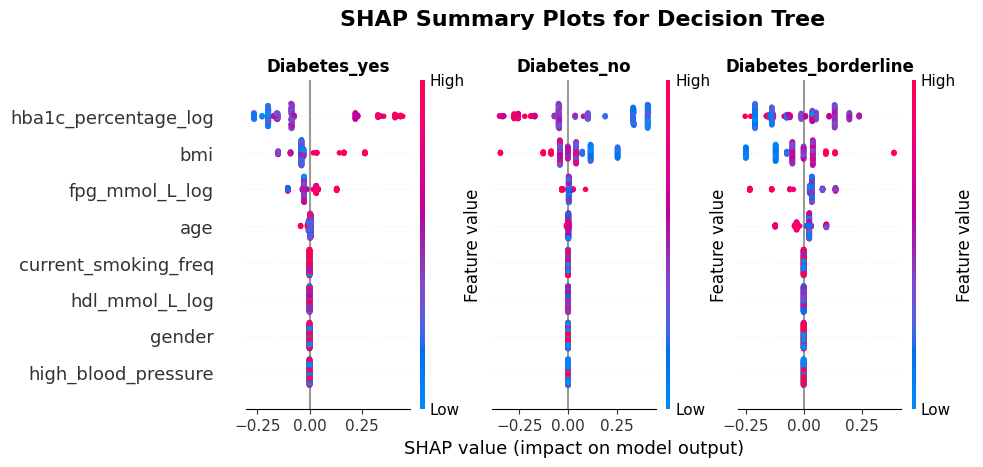

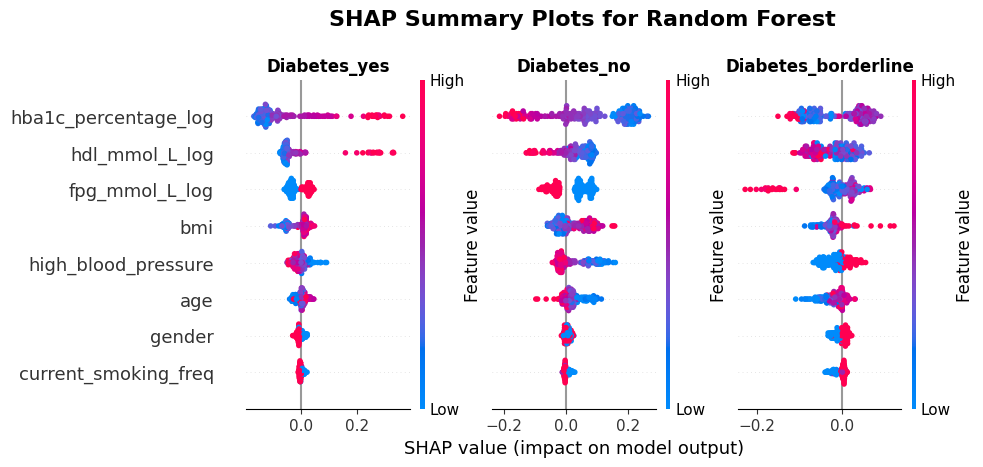

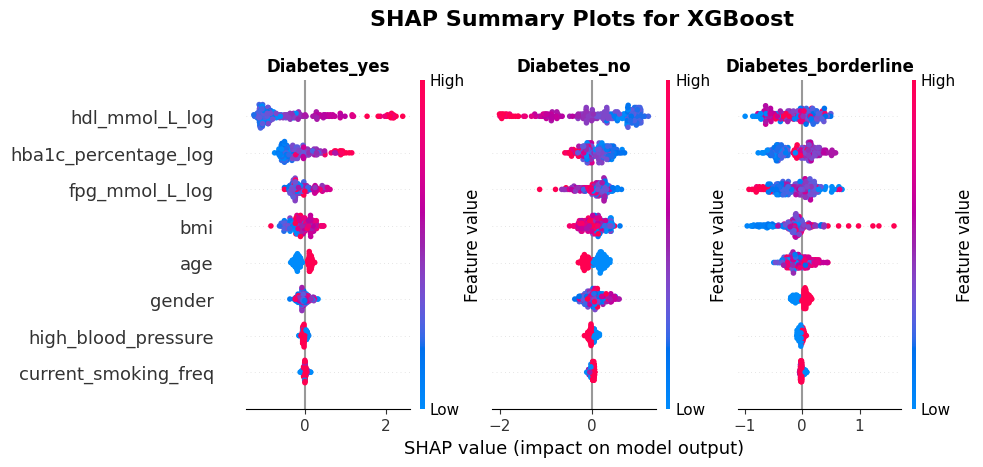

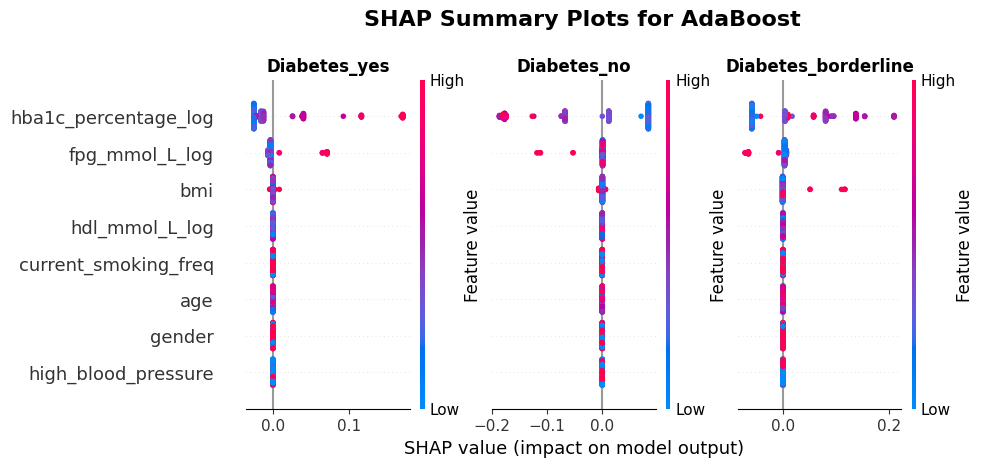

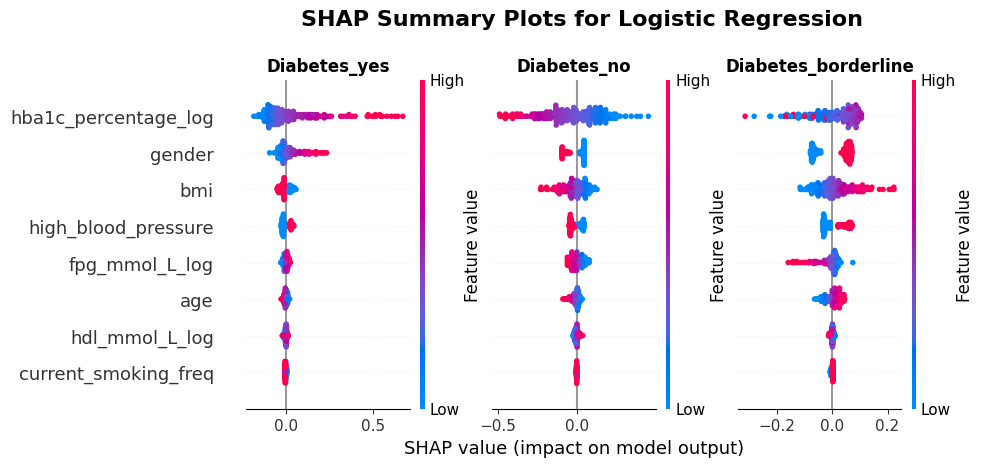

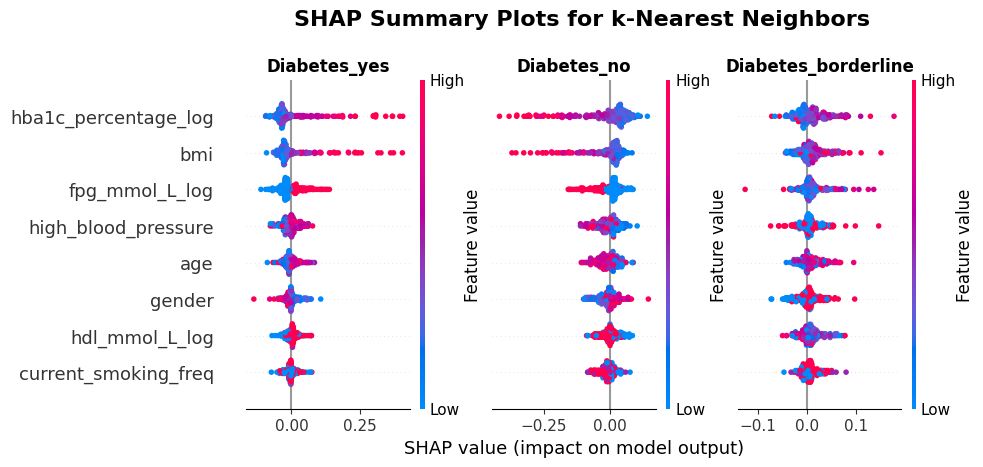

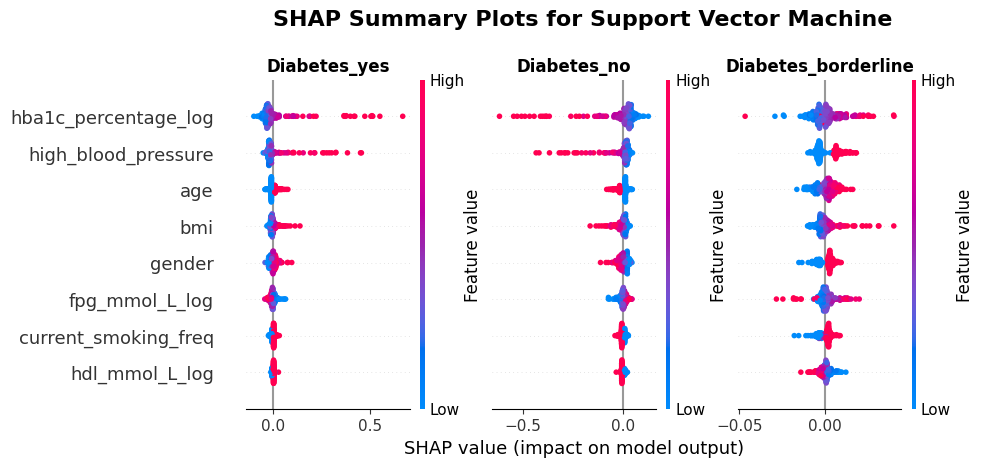

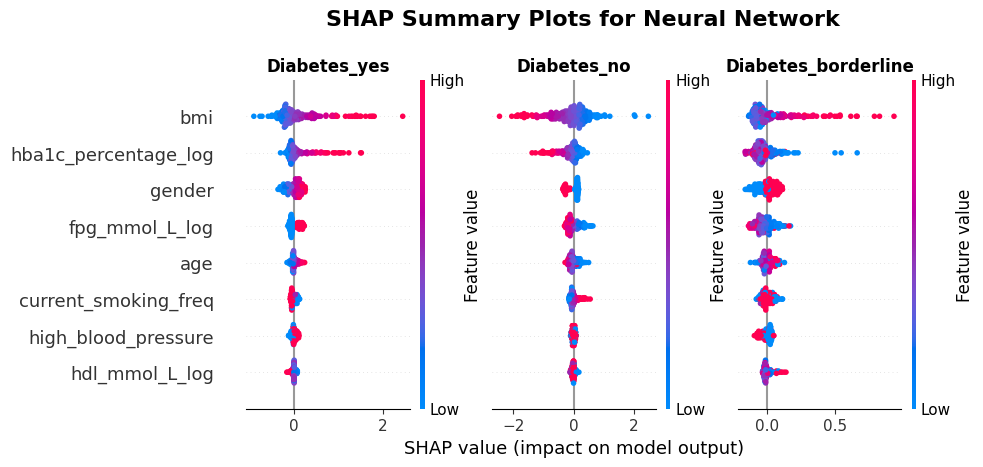

In [12]:
model_names = ["Decision Tree", "Random Forest", "XGBoost", "AdaBoost", "Logistic Regression", "k-Nearest Neighbors", "Support Vector Machine", "Neural Network"]
shap_values_list = [dt_shap_values, rf_shap_values, xgb_shap_values, adb_shap_values, lgr_shap_values, knn_shap_values, svc_shap_values, nn_shap_values]
class_names = ["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"]

for model_idx, (shap_values, model_name) in enumerate(zip(shap_values_list, model_names)):
    fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
    fig.suptitle(f"SHAP Summary Plots for {model_name}", fontweight="bold", y=1, fontsize=16)

    for class_idx in range(len(class_names)):
        ax = axes[class_idx]
        plt.sca(ax)
        
        X_data = X_test_scaled if model_name == "Neural Network" else X_test

        ax.set_title(f"{class_names[class_idx]}", fontweight="bold")
        shap.summary_plot(shap_values[:, :, class_idx], X_data, feature_names=feature_names, show=False)
        
        if class_idx != 1:
            ax.set_xlabel("")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.08, right=0.95, wspace=0.2)
    plt.show()